## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
# getting all the required  imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML


import matplotlib.pyplot as plt
%matplotlib inline

## First, I'll compute the camera calibration using chessboard images

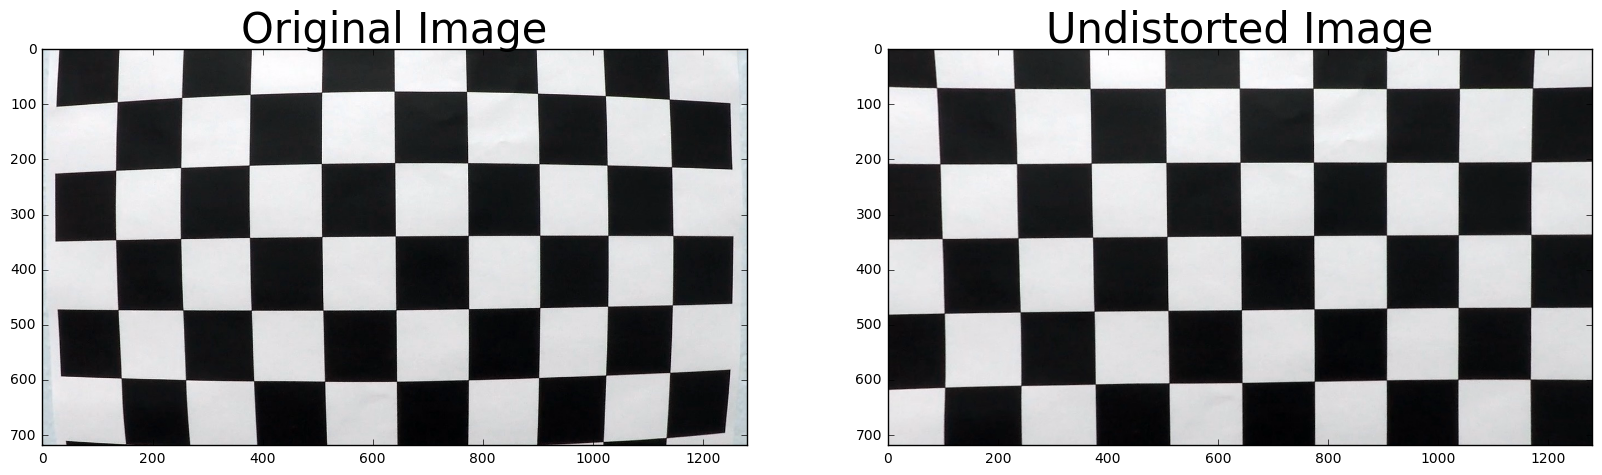

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()


# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

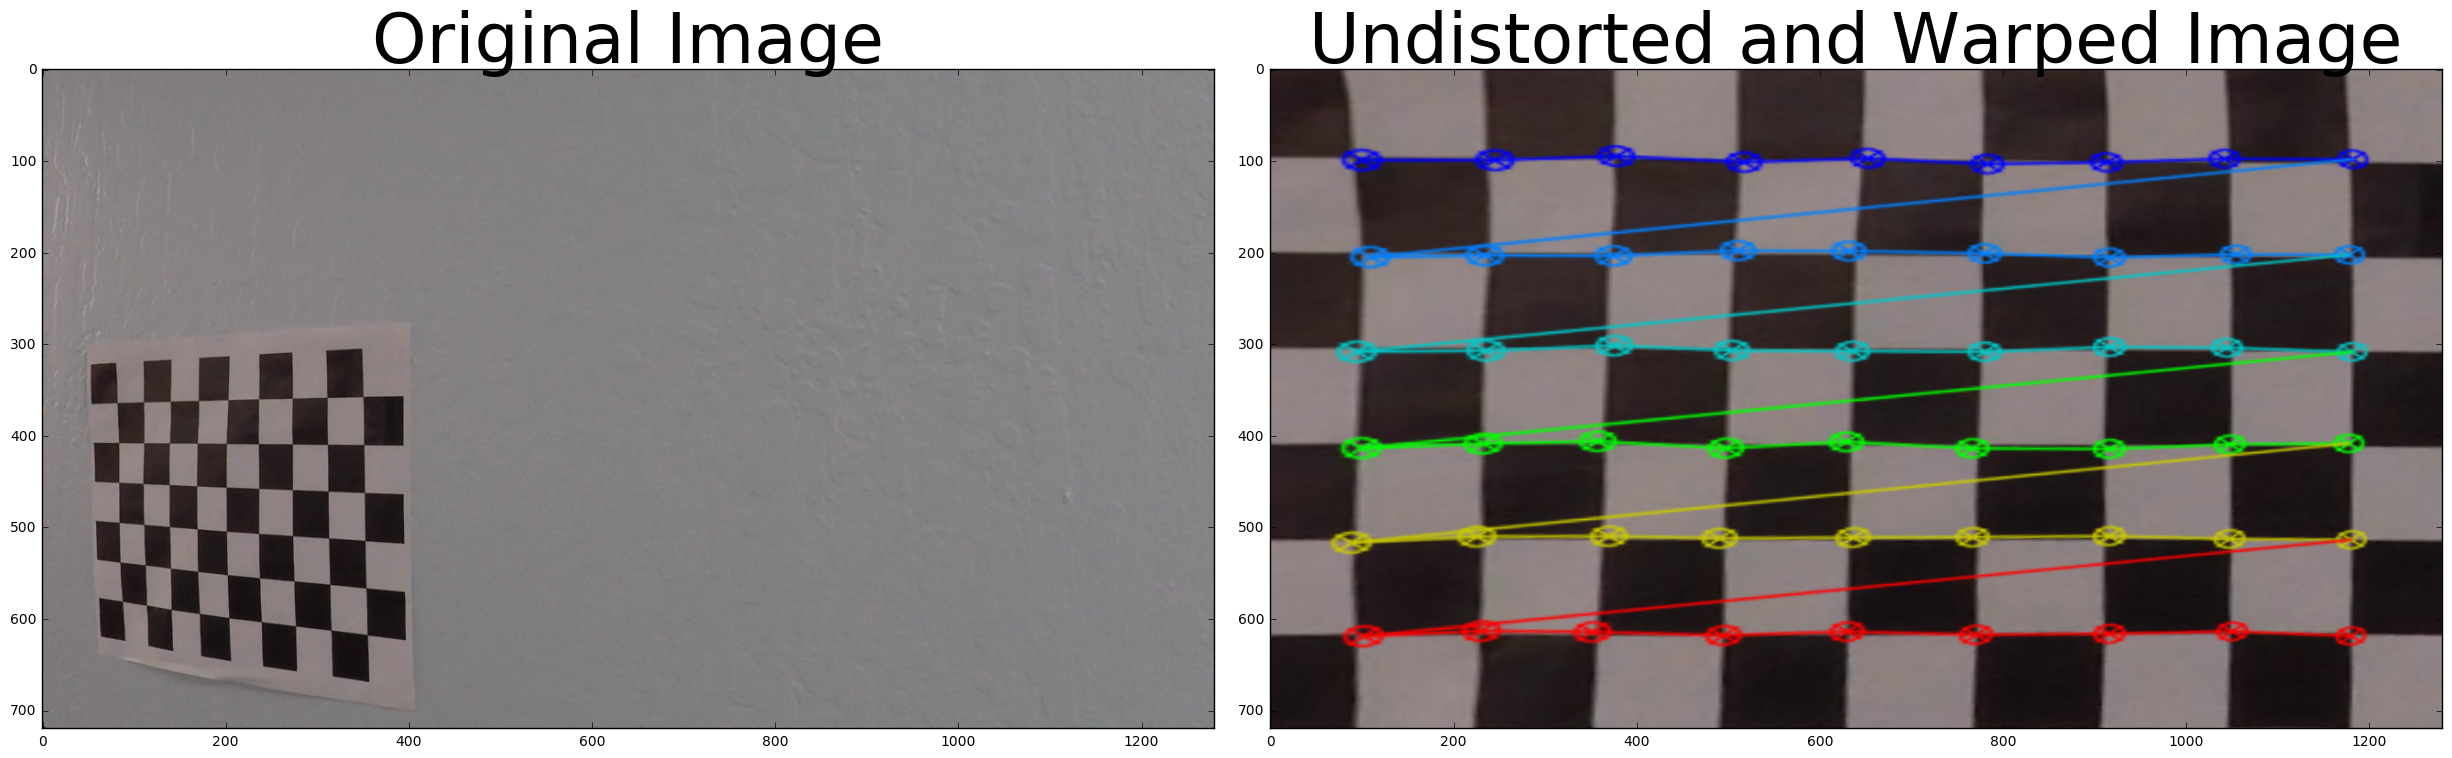

In [3]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration20.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

    
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## And so on and so forth...

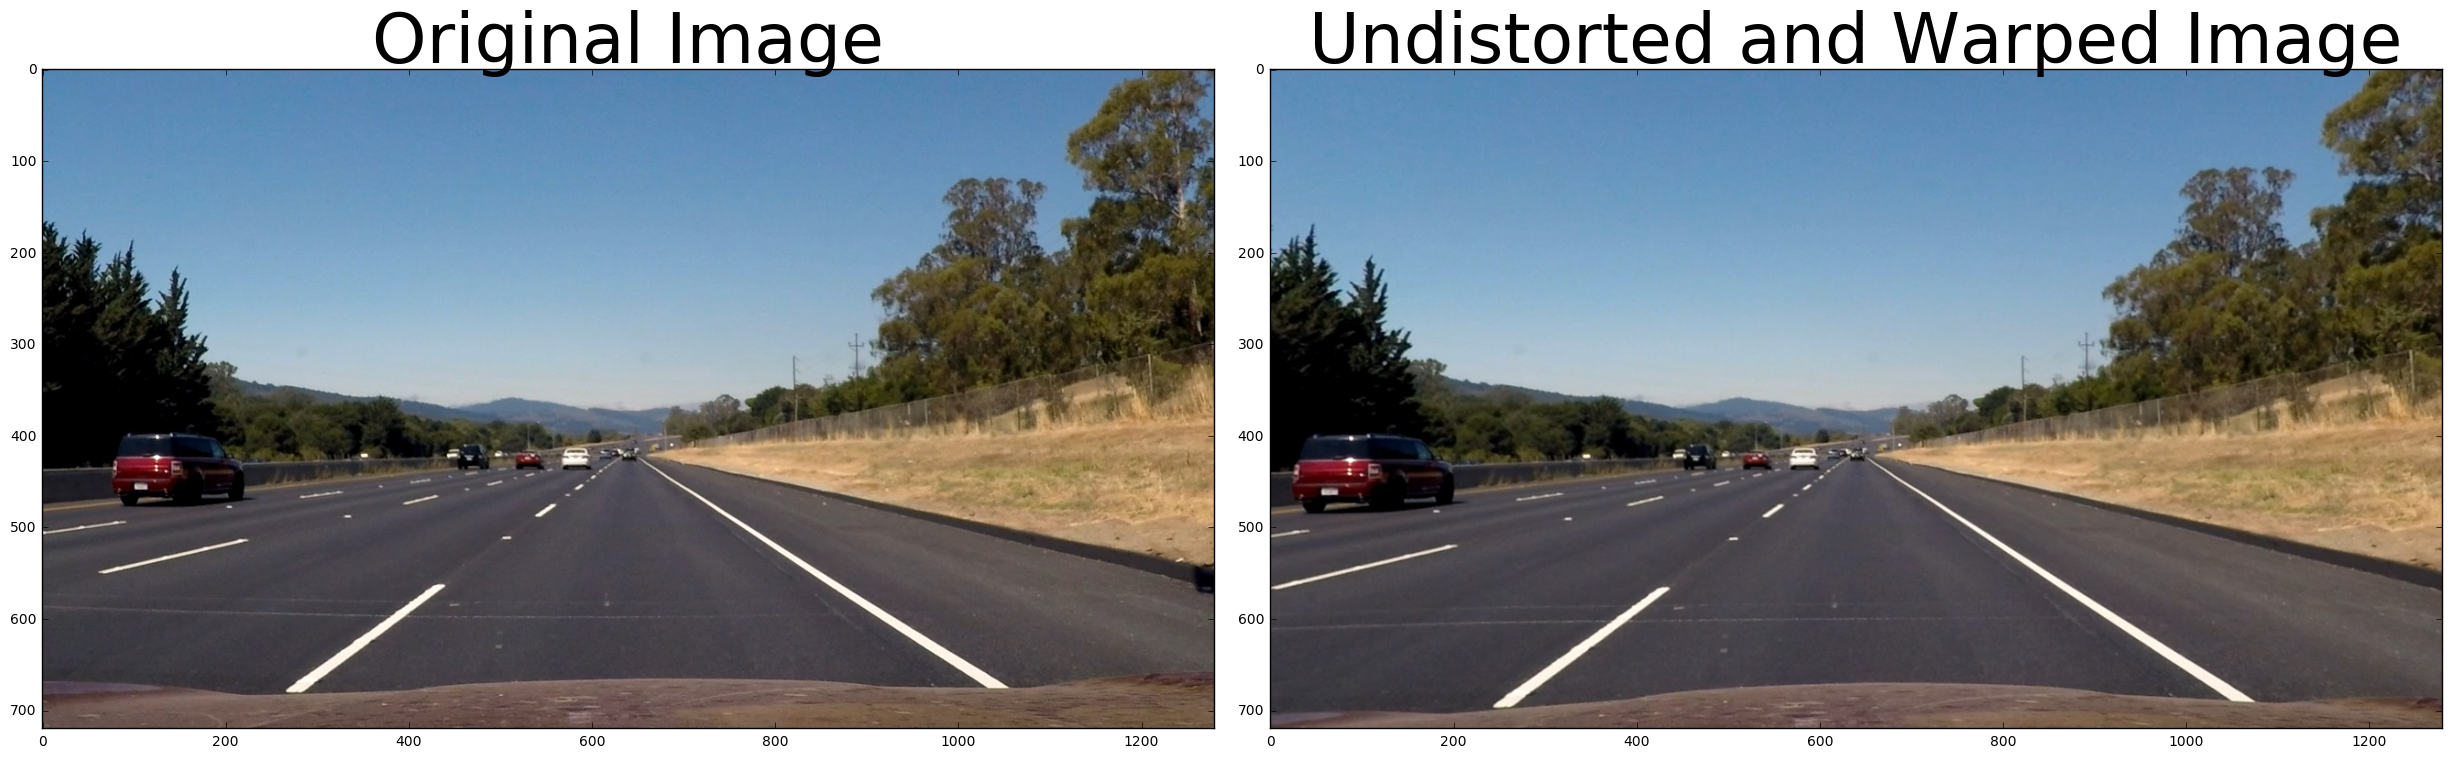

In [4]:
def undistortImage (img,mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('test_images/straight_lines2.jpg')
unDistortedImage = undistortImage(img,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(unDistortedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Functions to perform  color transforms, gradients to create a thresholded binary image. 


In [5]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output    


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def color_threshold(image, sthresh=(0, 255),vthresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=sthresh[0])&(s_channel<=sthresh[1])]= 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=vthresh[0])&(v_channel<=vthresh[1])] = 1
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

# this is to draw the masked image 
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [6]:
class tracker():
    def __init__(self,window_width,window_height,margin,ym=1,xm= 1,smooth_factor= 15):
        
        self.recent_centers =[]
        self.windows_width=window_width
        self.window_height = window_height
        self.margin = margin
        self.ym_per_pix = ym
        self.xm_per_pix = xm
        self.smooth_factor = smooth_factor

    def find_window_centroids(self,warped):

        window_width = self.windows_width
        window_height = self.window_height
        margin = self.margin

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
        
        self.recent_centers.append(window_centroids)
        return np.average(self.recent_centers[-self.smooth_factor:],axis = 0)

In [37]:
def process_image(image):

    ksize = 3
    
    image = undistortImage(image,mtx, dist)
    
    ## preprocessing the image to get relevent points by color thresholdinging and also filtering by sobel
    preprocessImage = np.zeros_like(image[:,:,0])
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    c_binary = color_threshold(image,sthresh=(100,255),vthresh=(50,255))
    #conbining all the filters
    preprocessImage[((gradx ==1)&(grady ==1)|(c_binary==1))] = 255

    
    # defineing perspective transformation area or the trapizoied/area of intrest
    image_size = (image.shape[1],image.shape[0])
    bottomWidth = .76 #.65 # percent of bottom trapizoied height
    midWidth= .08       #percent of middle trapizoid height
    hightPicture = .62  # percent of trapizoid height
    bottomTrim = 0.935  # percent from top to bottom to avoid car hood
    src = np.float32([[image.shape[1] * (.5 - midWidth / 2),image.shape[0] * hightPicture],
                      [image.shape[1] * (.5 + midWidth / 2),image.shape[0] * hightPicture],
                      [image.shape[1] * (.5 + bottomWidth / 2),image.shape[0] * bottomTrim],
                      [image.shape[1] * (.5 - bottomWidth / 2),image.shape[0] * bottomTrim]])
    offset =image_size[0] *.25
    dst = np.float32([[offset,0],[image_size[0]-offset,0],[image_size[0]-offset,image_size[1]],[offset,image_size[1]]])

    # perform pespective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
#     M,Minv,image_size =getPerspectiveTransformationValues(image)
    
    warped = cv2.warpPerspective(preprocessImage,M,image_size ,flags=cv2.INTER_LINEAR)

    #getting the centroid of each point based of sliding window
    window_width = 25 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 30# How much to slide left and right for searching
#     curve_center = tracker(window_width = window_width,window_height = window_height,margin = margin,ym=30/720,xm= 3.7/720,smooth_factor= 15)
    curve_center = tracker(window_width = window_width,window_height = window_height,margin = margin,ym=10/720,xm= 4/384,smooth_factor= 15)

    window_centroids = curve_center.find_window_centroids(warped)

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    leftx = []
    rightx =[]
    
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit  = np.polyfit(res_yvals ,leftx, 2) 
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)


    right_fit  = np.polyfit(res_yvals ,rightx, 2) 
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)


    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(image)
    road_bkg = np.zeros_like(image)

  
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])

    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_wrapped = cv2.warpPerspective(road,Minv,image_size,flags=cv2.INTER_LINEAR)
    road_wrapped_bkg = cv2.warpPerspective(road_bkg,Minv,image_size,flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(image,1.0,road_wrapped_bkg,-1.0,0.0)
    result = cv2.addWeighted(base,1.0,road_wrapped,0.7,0.0)


    # display metrics in the image 
    ym_per_pix = curve_center.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_center.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad =((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/ np.absolute(2*curve_fit_cr[0])

    camera_center= (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff<=0:
        side_pos = 'right'

    cv2.putText(result,"Radius of curvature = "+str(round(curverad,3))+"(m)",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,"Vehical is  = "+str(abs(round(center_diff,3)))+"(m) "+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    return result

In [38]:
## testing on sample images

images = glob.glob("test_images/test*.jpg")
print(images)
for i,imgPath in  enumerate(images):
    img = cv2.imread(imgPath)
    resultImage = process_image(img)
    cv2.imwrite("test_images/"+"resultantImage_"+str(i)+".jpg",resultImage)

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [39]:
output_video = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [03:18<00:00,  6.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 4min 53s, sys: 36.6 s, total: 5min 30s
Wall time: 3min 19s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))